# Imports

In [1]:
import os
print(os.listdir("../input"))

!git clone https://github.com/mebn/ultralytics.git
!cd ultralytics && git pull && cd ..

import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models.feature_extraction import create_feature_extractor
import cv2
import matplotlib.pyplot as plt

import sys
sys.path.append("/kaggle/working/ultralytics")
from ultralytics import YOLO

['seadronessee-yolo-2000a']
Cloning into 'ultralytics'...
remote: Enumerating objects: 36449, done.
remote: Total 36449 (delta 0), reused 0 (delta 0), pack-reused 36449 (from 1)
Receiving objects: 100% (36449/36449), 22.19 MiB | 20.45 MiB/s, done.
Resolving deltas: 100% (26319/26319), done.
Already up to date.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Replacing backbone and initialization

In [2]:
model_file = "/kaggle/working/model.yaml"


with open(model_file, "w") as f:
    f.write("""
nc: 80  # number of classes

scales:
  n: [1, 1, 1024]  # actual architecture below is scaled to match n: [0.5, 0.25, 1024]

backbone:
  - [-1, 1, TorchVision, [464, shufflenet_v2_x1_0, DEFAULT, True, 2, True]] # 0

head:
  - [0, 1, Index, [116, 5]]           # 1: P3
  - [1, 1, CA, [116]]                 # 2
  - [0, 1, Index, [232, 6]]           # 3: P4
  - [3, 1, CA, [232]]                 # 4
  - [0, 1, Index, [464, 7]]           # 5: P5
  - [5, 1, CA, [464]]                 # 6

  # Project to scaled YOLOv11 channel sizes (256 → 64, 512 → 128, 1024 → 256)
  - [2, 1, Conv, [64, 1, 1]]         # 7: P3 → 64
  - [4, 1, Conv, [128, 1, 1]]        # 8: P4 → 128
  - [6, 1, Conv, [256, 1, 1]]        # 9: P5 → 256

  # FPN: P5 → P4
  - [9, 1, nn.Upsample, [None, 2, "nearest"]]  # 10
  - [[10, 8], 1, Concat, [1]]                  # 11
  - [-1, 1, C3k2, [128, False]]                # 12 (2 → 1 repeat, 512 → 128)

  # FPN: P4 → P3
  - [12, 1, nn.Upsample, [None, 2, "nearest"]]  # 13
  - [[13, 7], 1, Concat, [1]]                   # 14
  - [-1, 1, C3k2, [64, False]]                  # 15 (256 → 64)

  # PAN: P3 → P4
  - [15, 1, Conv, [64, 3, 2]]                   # 16
  - [[16, 12], 1, Concat, [1]]                  # 17
  - [-1, 1, C3k2, [128, False]]                 # 18

  # PAN: P4 → P5
  - [18, 1, Conv, [128, 3, 2]]                  # 19
  - [[19, 9], 1, Concat, [1]]                   # 20
  - [-1, 1, C3k2, [256, True]]                  # 21

  # Final detection layers
  - [[15, 18, 21], 1, Detect, [nc]]             # 22

  

  
# backbone layers:
# 0 torch.Size([1, 3, 640, 640])
# 1 torch.Size([1, 24, 320, 320])
# 2 torch.Size([1, 24, 320, 320])
# 3 torch.Size([1, 24, 320, 320])
# 4 torch.Size([1, 24, 160, 160])
# 5 torch.Size([1, 116, 80, 80])
# 6 torch.Size([1, 232, 40, 40])
# 7 torch.Size([1, 464, 20, 20])
""")


model = YOLO(model_file, task="detect")

# img = torch.randn(1, 3, 640, 640)
# output = model.model(img)
# for o in output:
#     print(o.shape)

WARNING ⚠️ no model scale passed. Assuming scale='n'.


Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 117MB/s]


# Data

In [3]:
data_file = "/kaggle/working/data.yaml"


with open(data_file, "w") as f:
    f.write("""train: /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train
val: /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/val
test: /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/test
nc: 1
names: ["human"]""")

# Fine-tuning

In [4]:
model.train(
    data=data_file,
    epochs=300,
    patience=10,
    imgsz=640,
    batch=16,
    name="model"
)

New https://pypi.org/project/ultralytics/8.3.116 available 😃 Update with 'pip install -U ultralytics'
WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/working/model.yaml, data=/kaggle/working/data.yaml, epochs=300, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=Fals

100%|██████████| 755k/755k [00:00<00:00, 4.10MB/s]
E0000 00:00:1745653276.450047      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745653276.504320      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=1
WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1    776420  ultralytics.nn.modules.block.TorchVision     ['shufflenet_v2_x1_0', 'DEFAULT', True, 2, True]
  1                   0  1         0  ultralytics.nn.modules.conv.Index            [5]                           
  2                   1  1      3040  ultralytics.nn.modules.conv.CA               [116]                         
  3                   0  1         0  ultralytics.nn.modules.conv.Index            [6]                           
  4                   3  1      6056  ultralytics.nn.modules.conv.CA               [232]                         
  5                   0  1         0  ultralytics.nn.modules.conv.Index            [7]                           
  6                   5  1     20458  ultralytics.nn.modules.conv.CA               [464]   

100%|██████████| 5.35M/5.35M [00:00<00:00, 17.3MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels/train... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:10<00:00, 199.16it/s]

train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9561.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9563.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9564.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9565.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9569.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9570.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/train/9571.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels/val... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:01<00:00, 162.63it/s]

val: WARNING ⚠️ /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/val/9560.jpg: 1 duplicate labels removed
val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels is not writeable, cache not saved.


WARNING ⚠️ 'name=model' automatically updated to 'name=/kaggle/working/model'.
Plotting labels to /kaggle/working/model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 102 weight(decay=0.0), 115 weight(decay=0.0005), 117 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/model
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      1/300      2.71G       4.24      24.66      2.908        138        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]

                   all        250       1262    0.00067     0.0293   0.000345   8.22e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      2/300      3.39G      3.186      2.991      1.299        108        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

                   all        250       1262      0.374      0.297      0.179     0.0413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      3/300      3.39G      3.003      2.273      1.193        107        640: 100%|██████████| 125/125 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.45it/s]

                   all        250       1262      0.443      0.313      0.242     0.0579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      4/300      3.39G      2.869      1.937      1.152        197        640: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.87it/s]

                   all        250       1262      0.528      0.383      0.339     0.0908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      5/300      3.39G      2.738      1.665      1.146        111        640: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]

                   all        250       1262      0.504       0.41      0.343     0.0927



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      6/300      3.39G      2.692      1.536      1.107        141        640: 100%|██████████| 125/125 [00:52<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

                   all        250       1262      0.559      0.391      0.356      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      7/300      3.39G      2.684      1.447      1.123        128        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.61it/s]

                   all        250       1262       0.56        0.4      0.371      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      8/300      3.39G      2.555      1.334      1.099        134        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]

                   all        250       1262      0.555      0.417        0.4      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      9/300      3.39G      2.573      1.303       1.08        155        640: 100%|██████████| 125/125 [00:52<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.35it/s]

                   all        250       1262      0.572      0.481       0.45      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     10/300      3.39G      2.576      1.281      1.083        163        640: 100%|██████████| 125/125 [00:54<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]

                   all        250       1262      0.616       0.41      0.434      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     11/300      3.39G      2.476      1.199      1.042        126        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.31it/s]

                   all        250       1262      0.593      0.443      0.435      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     12/300      3.39G      2.467      1.204      1.079        141        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

                   all        250       1262      0.621      0.473      0.469      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     13/300      3.39G      2.423      1.182      1.069        132        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]

                   all        250       1262      0.657      0.477      0.475      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     14/300      3.39G      2.426      1.164       1.04        173        640: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.64it/s]

                   all        250       1262      0.658      0.468      0.504      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     15/300      3.39G      2.389      1.141      1.038        122        640: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.46it/s]

                   all        250       1262      0.637      0.496      0.492      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     16/300      3.39G      2.414      1.124      1.036        120        640: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.52it/s]

                   all        250       1262      0.627      0.466      0.468      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     17/300      3.39G      2.391      1.136      1.045         95        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.76it/s]

                   all        250       1262      0.664      0.484      0.495      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     18/300      3.39G      2.406      1.115      1.029        121        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

                   all        250       1262      0.614      0.453      0.447      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     19/300      3.39G      2.373      1.123      1.047        144        640: 100%|██████████| 125/125 [00:56<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.61it/s]

                   all        250       1262      0.691      0.446      0.477      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     20/300      3.39G       2.35      1.091       1.04        148        640: 100%|██████████| 125/125 [00:56<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.94it/s]

                   all        250       1262      0.654      0.459      0.474      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     21/300      3.39G      2.327      1.088       1.02        168        640: 100%|██████████| 125/125 [00:56<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.39it/s]


                   all        250       1262      0.638      0.468      0.463      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     22/300      3.39G      2.274      1.068      1.029        138        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.62it/s]

                   all        250       1262      0.623      0.463      0.463      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     23/300      3.39G      2.313      1.056      1.023        193        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.43it/s]

                   all        250       1262      0.607      0.475      0.483      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     24/300      3.39G      2.303      1.084      1.018        148        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.82it/s]

                   all        250       1262      0.639      0.501      0.507      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     25/300      3.39G      2.224      1.027     0.9965        169        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]

                   all        250       1262      0.639      0.493      0.495      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     26/300      3.39G      2.235      1.028      1.001        116        640: 100%|██████████| 125/125 [00:55<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.11it/s]

                   all        250       1262      0.669       0.49      0.521      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     27/300      3.39G      2.268      1.044      1.024        163        640: 100%|██████████| 125/125 [00:57<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.03it/s]

                   all        250       1262      0.702      0.518      0.546      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     28/300      3.39G       2.25      1.038      1.007        131        640: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.92it/s]

                   all        250       1262      0.703      0.494      0.517      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     29/300      3.39G      2.227      1.036      1.013        113        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.41it/s]

                   all        250       1262      0.679      0.518      0.553      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     30/300      3.39G      2.206      1.025     0.9973        112        640: 100%|██████████| 125/125 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.03it/s]

                   all        250       1262      0.699      0.511      0.539      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     31/300      3.39G      2.226      1.028      1.006        119        640: 100%|██████████| 125/125 [00:53<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

                   all        250       1262      0.652      0.482      0.498      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     32/300      3.39G      2.227      1.035      1.008        151        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.36it/s]

                   all        250       1262      0.651      0.529      0.539      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     33/300      3.39G      2.189      1.005     0.9961        113        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.47it/s]

                   all        250       1262      0.654      0.511      0.518      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     34/300      3.39G      2.187      1.018     0.9976        142        640: 100%|██████████| 125/125 [00:54<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.56it/s]

                   all        250       1262      0.689      0.522      0.543      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     35/300      3.39G      2.199      1.005     0.9937        130        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.46it/s]

                   all        250       1262      0.659      0.516      0.549      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     36/300      3.39G      2.221      1.016     0.9992        130        640: 100%|██████████| 125/125 [00:54<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.37it/s]

                   all        250       1262      0.631      0.535      0.537       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     37/300      3.39G      2.157     0.9826     0.9862        146        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

                   all        250       1262       0.68      0.525      0.534      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     38/300      3.39G      2.149     0.9704     0.9847        128        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]

                   all        250       1262      0.695      0.539      0.564       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     39/300      3.39G      2.132     0.9665     0.9853        120        640: 100%|██████████| 125/125 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.00it/s]

                   all        250       1262      0.689      0.522      0.557      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     40/300      3.39G      2.128     0.9636     0.9873        130        640: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.58it/s]

                   all        250       1262      0.686      0.522      0.553        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     41/300      3.39G      2.162     0.9896     0.9905        172        640: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.35it/s]

                   all        250       1262      0.682      0.529      0.563      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     42/300      3.39G      2.117     0.9717     0.9845        149        640: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.21it/s]

                   all        250       1262      0.669      0.513       0.54      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     43/300      3.39G      2.195      1.005     0.9969        125        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.18it/s]

                   all        250       1262      0.667       0.51      0.541      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     44/300      3.39G      2.135     0.9574     0.9778        105        640: 100%|██████████| 125/125 [00:55<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.43it/s]

                   all        250       1262      0.694      0.547      0.573      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     45/300      3.39G      2.124     0.9803     0.9912        150        640: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]

                   all        250       1262      0.712      0.519      0.552      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     46/300      3.39G      2.119     0.9622     0.9774        132        640: 100%|██████████| 125/125 [00:55<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.67it/s]

                   all        250       1262      0.706      0.547      0.569      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     47/300      3.39G      2.117     0.9504     0.9755        147        640: 100%|██████████| 125/125 [00:55<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.45it/s]

                   all        250       1262      0.713      0.548      0.575      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     48/300      3.39G      2.095     0.9526     0.9673        114        640: 100%|██████████| 125/125 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

                   all        250       1262      0.702      0.511      0.552      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     49/300      3.39G      2.076     0.9439     0.9767        169        640: 100%|██████████| 125/125 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.24it/s]

                   all        250       1262      0.704      0.553      0.582      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     50/300      3.39G      2.081     0.9425     0.9736         92        640: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.27it/s]


                   all        250       1262       0.72      0.544      0.567      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     51/300      3.39G      2.111     0.9507     0.9803        132        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]


                   all        250       1262      0.701      0.545      0.574      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     52/300      3.39G      2.047     0.9184       0.97        104        640: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.71it/s]

                   all        250       1262      0.702      0.567      0.581      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     53/300      3.39G      2.101     0.9415     0.9762        181        640: 100%|██████████| 125/125 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.80it/s]


                   all        250       1262      0.691      0.566      0.592      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     54/300      3.39G      2.082     0.9445     0.9759        157        640: 100%|██████████| 125/125 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.30it/s]

                   all        250       1262       0.72      0.533      0.576      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     55/300      3.39G      2.107     0.9713     0.9824        174        640: 100%|██████████| 125/125 [00:52<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.12it/s]

                   all        250       1262      0.727      0.538       0.57      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     56/300      3.39G      2.063     0.9164     0.9679        153        640: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]

                   all        250       1262      0.693      0.554      0.578      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     57/300      3.39G       2.06     0.9146     0.9824        162        640: 100%|██████████| 125/125 [00:54<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

                   all        250       1262      0.699      0.546       0.57      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     58/300      3.39G      2.031     0.9002     0.9541        147        640: 100%|██████████| 125/125 [00:53<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.17it/s]

                   all        250       1262      0.728      0.546      0.589      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     59/300      3.39G      2.061     0.9275     0.9663        105        640: 100%|██████████| 125/125 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.79it/s]

                   all        250       1262      0.729      0.526      0.568      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     60/300      3.39G      2.026      0.907     0.9653         98        640: 100%|██████████| 125/125 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.74it/s]

                   all        250       1262      0.681      0.533      0.568      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     61/300      3.39G      2.064      0.934     0.9602         80        640: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]

                   all        250       1262      0.688      0.518      0.539      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     62/300      3.39G      2.034      0.907      0.958         98        640: 100%|██████████| 125/125 [00:54<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.25it/s]

                   all        250       1262      0.709      0.552      0.568      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: adaptive_avg_pool2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
     63/300      3.39G      1.991     0.8838     0.9509        109        640: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.80it/s]

                   all        250       1262      0.701      0.558      0.585       0.22
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 53, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



63 epochs completed in 1.006 hours.
Optimizer stripped from /kaggle/working/model/weights/last.pt, 4.7MB
Optimizer stripped from /kaggle/working/model/weights/best.pt, 4.7MB

Validating /kaggle/working/model/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 245 layers, 2,179,289 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


                   all        250       1262      0.689      0.566      0.592      0.224


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a70a296a090>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Testing

In [5]:
def show_img_with_boxes(res):
    img = res[0].plot()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


image 1/1 /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/test/10209.jpg: 384x640 5 humans, 53.4ms
Speed: 2.2ms preprocess, 53.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


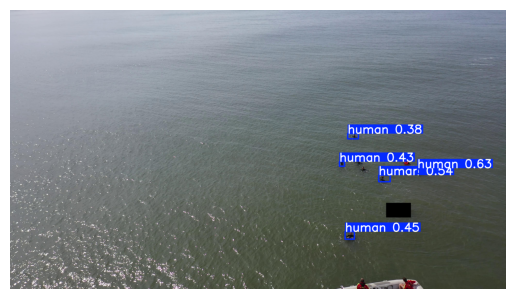

Ultralytics 8.3.103 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
model summary: 245 layers, 2,179,289 parameters, 0 gradients


val: Scanning /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels/test... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:01<00:00, 134.52it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]


                   all        250       1350      0.716      0.605      0.623      0.241


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.4ms preprocess, 3.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a709d2f5650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [6]:
model = YOLO("/kaggle/working/model/weights/best.pt")

img = "/kaggle/input/seadronessee-yolo-2000a/seaDronesSee_yolo2000/images/test/10209.jpg"

results = model(img)
show_img_with_boxes(results)

model.val(
    data=data_file,
    split="test"
)